In [ ]:
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss
from torch.optim import Adam
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from skimage.color import rgb2lab, rgb2gray, lab2rgb

import matplotlib.pyplot as plt
height, width = 600, 400

In [ ]:
! unzip ./drive/MyDrive/data.zip

Výstupní stream byl oříznut na posledních 5000 řádků.
  inflating: grey_images/gustave-courbet_riverside.jpg  
  inflating: grey_images/cubismo_87.jpg  
  inflating: grey_images/childe-hassam_evening.jpg  
  inflating: grey_images/alfred-sisley_the-road-from-hampton-court-1874.jpg  
  inflating: grey_images/cubismo_1.jpg  
  inflating: grey_images/childe-hassam_old-lyme-bridge.jpg  
  inflating: grey_images/pierre-bonnard_dauphine-landscape.jpg  
  inflating: grey_images/portrait-of-giovanni-arnolfini-1435.jpg  
  inflating: grey_images/vincent-van-gogh_the-bois-de-boulogne-with-people-walking-1886.jpg  
  inflating: grey_images/frederic-bazille_the-little-gardener.jpg  
  inflating: grey_images/a-scene-on-the-bridge-and-beld-1.jpg  
  inflating: grey_images/camille-pissarro_the-church-and-farm-of-eragny-1895.jpg  
  inflating: grey_images/maximilien-luce_landscape.jpg  
  inflating: grey_images/claude-monet_river-thawing-near-vetheuil.jpg  
  inflating: grey_images/romantis_80.jpg  
 

In [ ]:
os.listdir()

['.config', 'drive', 'dataset', 'grey_images', 'sample_data']

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, list_names, color_img_dir, grey_img_dir, transform=None, target_transform=None):
        self.img_names = list_names
        self.color_img_dir = color_img_dir
        self.grey_img_dir = grey_img_dir
        self.transform=transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        color_img_path = os.path.join(self.color_img_dir, self.img_names[idx])
        grey_img_path = os.path.join(self.grey_img_dir, self.img_names[idx])
        color_image = rgb2lab(Image.open(color_img_path).resize((height, width)))
        grey_image = Image.open(grey_img_path).resize((height, width))
        if self.transform:
            color_img = self.transform(color_image)
            grey_img = self.transform(grey_image)
        return grey_img, color_img

In [ ]:
df = ImageDataset(os.listdir("./dataset"), "dataset", "grey_images", ToTensor())

In [ ]:
data_loader = DataLoader(df, batch_size=16, shuffle=True)

torch.Size([1, 400, 600])
torch.Size([3, 400, 600])
tensor([[ 0.5572,  0.0414, -1.1187,  ..., -6.3530, -6.3792, -6.4128],
        [ 1.6016,  1.0774,  1.0691,  ..., -6.4128, -6.3858, -6.2500],
        [ 2.7188,  2.7426,  2.2468,  ..., -6.7201, -6.6981, -6.6695],
        ...,
        [30.7032, 32.7028, 36.0241,  ..., 20.1342, 20.5395, 21.0806],
        [33.7697, 32.9091, 33.0860,  ..., 20.0318, 20.9442, 20.8450],
        [35.0548, 32.5790, 29.2405,  ..., 20.3847, 21.3313, 21.7599]],
       dtype=torch.float64)


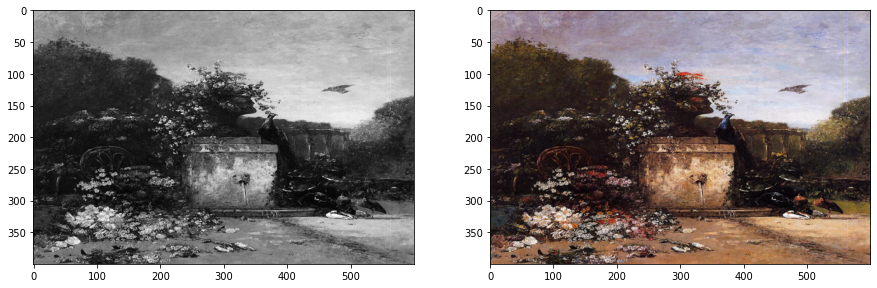

In [ ]:
grey_img, color_img = next(iter(data_loader))

print(grey_img[0].shape)
print(color_img[0].shape)
print(color_img[0][2])
f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(grey_img[0].numpy()[0], cmap='gray')
axarr[1].imshow(lab2rgb(np.transpose(color_img[0].numpy(), (1,2,0))))

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(os.listdir("./dataset"), np.zeros(len(os.listdir("./dataset"))), test_size=0.35, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, np.zeros(len(X_test)), test_size=0.6, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

4473
1446
964


In [ ]:
train_data = ImageDataset(X_train, "dataset", "grey_images", ToTensor())
val_data = ImageDataset(X_val, "dataset", "grey_images", ToTensor())
test_data = ImageDataset(X_test, "dataset", "grey_images", ToTensor())


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
# PyTorch models inherit from torch.nn.Module
# for now it is a very simple network - I needed to resolve the issues I had with the input and other errors
class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layers = Sequential(
        Conv2d(1, 64, 3, stride=1, padding=1),
        BatchNorm2d(64),
        ReLU(), 
        Conv2d(64, 32, 3, stride=1, padding=1),
        BatchNorm2d(32),
        ReLU(), 
        Conv2d(32, 2, 3, stride=1, padding=1)
    )    

  def forward(self, x):
    x = self.layers(x)
    return x

In [ ]:
def train(model, train_loader, optimizer, trainset_len):
    model.train()
    train_loss = 0
    train_correct = 0
    bnum = 0

    model.zero_grad() # set the gradients to zero because PyTorch accumulates the gradients

    for i, (data, target) in enumerate(train_loader):      
        
        output = model(data)

        # Compute the loss and its gradients
        loss = criterion(output.float(), target[:, 1:, :].float())
    
        #_, preds = torch.max(output.data, 1)
        
        train_loss += loss.item()
        #train_correct += torch.sum(preds == target[0]).item()
        
        loss.backward() # calculate backpropagation path
        optimizer.step() # take a step on the loss surface
        model.zero_grad()

    train_loss /= len(train_loader)

    return train_loss

In [ ]:
def test(model, test_loader, testset_len):
    model.eval()
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            
            output = model(data[0])
            
            test_loss += criterion(output.float(), target[0][1:].float()).item()
            
            #_, preds = torch.max(output.data, 1)
            
            #test_correct += torch.sum(preds == target[0]).item()

    test_loss /= len(test_loader)

    print('\nValidation loss: {:.4f}'.format(
        test_loss
        )
    )
    print('Validation Accuracy: {:.2f} %'.format(
        test_correct/testset_len*100, 
        )
    )

    return test_loss, test_correct/testset_len*100

In [ ]:

model = CNN()

optimizer = Adam(model.parameters(), lr=0.07)

criterion = MSELoss()

In [ ]:
num_epochs = 1
train_loss_output = []
val_loss_output = []

for epoch in range(1, num_epochs + 1):
    tr_loss = train(model=model,
                    train_loader=train_loader,
                    optimizer=optimizer, 
                    trainset_len=len(X_train)
                    )
    print("Epoch:", epoch, ", loss: ", tr_loss)
    #vl_loss = test(model, test_loader, len(X_test))

    train_loss_output.append(tr_loss)
    #val_loss_output.append(vl_loss)

Epoch: 1
Batch: 0
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 1
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 2
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 3
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 4
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 5
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 6
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 7
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 8
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
Batch: 9
torch.Size([32, 1, 400, 600])
torch.Size([32, 3, 400, 600])
torch.Size([32, 2, 400, 600])
B

In [ ]:
data_loader = DataLoader(df, batch_size=1, shuffle=True)

In [ ]:
grey_img, color_img = next(iter(data_loader))

output = model(grey_img)

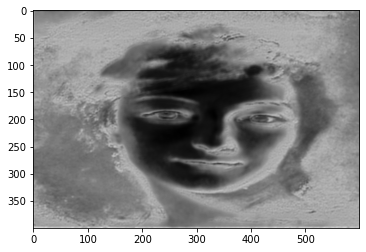

In [ ]:
plt.imshow(output.detach().numpy()[0][0], cmap='gray')
plt.show()

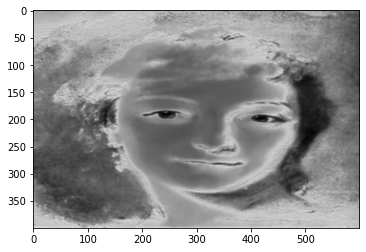

In [ ]:
plt.imshow(output.detach().numpy()[0][1], cmap='gray')
plt.show()

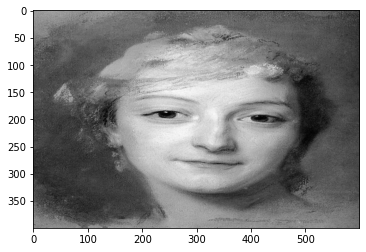

In [ ]:
plt.imshow(color_img[0][0], cmap='gray')
plt.show()

In [ ]:
output.shape

torch.Size([1, 2, 400, 600])

In [ ]:
output_img = np.concatenate([grey_img[0], output.detach().numpy()[0]], axis=0)
print(output_img.shape)

(3, 400, 600)


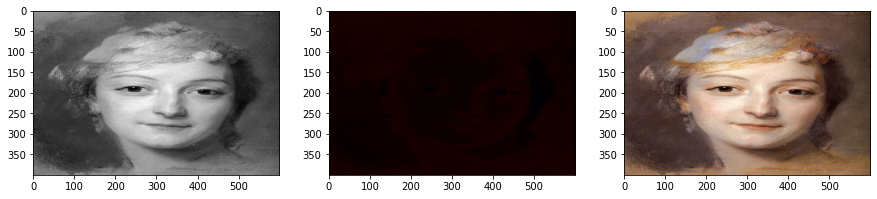

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(15, 15))
axarr[0].imshow(grey_img[0].numpy()[0], cmap='gray')
axarr[1].imshow(lab2rgb(np.transpose(output_img, (1, 2, 0))))
axarr[2].imshow(lab2rgb(np.transpose(color_img[0].numpy(), (1,2,0))))

plt.show()